In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import pandas as Pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr
from PIL import Image
import os

**•	TensorFlow and Keras:** Core tools for building and training your image classification model.
**•	EfficientNetV2B0:** A pre-built, powerful model that's already good at recognizing images. Using it saves a lot of time and effort compared to building a model from scratch.
**•	NumPy and Pandas:** For handling and organizing your data (like image information and labels) before and after you work with the AI model.
**•	Matplotlib and Seaborn:** Help you visualize your data and the results of your model performance.
**•	Scikit-learn metrics:** These give you ways to measure how good your model is at classifying images.
**•	Gradio: **This helps you create a simple web interface to test out your trained model with your own images.
**•	PIL (Pillow): **This is for opening and working with the image files themselves.
**•	OS:** This helps you navigate and interact with the folders and files on your computer.

In [4]:
import kagglehub

# Dataset path
path = kagglehub.dataset_download("akshat103/e-waste-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/akshat103/e-waste-image-dataset/versions/1


In [5]:
# Dataset path from kagglehub download
dataset_base_path = "/kaggle/input/e-waste-image-dataset"

#Training datset path
train_folder = os.path.join(dataset_base_path, "modified-dataset", "train")
#Testing datset path
test_folder = os.path.join(dataset_base_path, "modified-dataset", "test")
#Validation dataset path
val_folder = os.path.join(dataset_base_path, "modified-dataset", "val")

In [31]:
data_train= tf.keras.utils.image_dataset_from_directory(train_folder,shuffle=True,image_size=(150,150),batch_size=32,validation_split=False)
data_test= tf.keras.utils.image_dataset_from_directory(test_folder,shuffle=False,image_size=(150,150),batch_size=32,validation_split=False)
data_val= tf.keras.utils.image_dataset_from_directory(val_folder,shuffle=True,image_size=(150,150),batch_size=32,validation_split=False)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [8]:
def get_counts(folder):
  counts={}
  for class_folder in os.listdir(folder) :
    class_path = os.path.join(folder,class_folder)
    if os.path.isdir(class_path):
      counts[class_folder] = len(os.listdir(class_path))
  return counts
train_counts = get_counts(train_folder)
test_counts = get_counts(test_folder)
val_counts = get_counts(val_folder)
print(len(data_train.class_names))
print("Training data")
print(train_counts)
print("Testing data")
print(test_counts)
print("Validation data")
print(val_counts)
#This block contains the counts of the individual datasets(files) that is trained,test and split

10
Training data
{'PCB': 240, 'Television': 240, 'Microwave': 240, 'Mouse': 240, 'Battery': 240, 'Washing Machine': 240, 'Mobile': 240, 'Keyboard': 240, 'Player': 240, 'Printer': 240}
Testing data
{'PCB': 30, 'Television': 30, 'Microwave': 30, 'Mouse': 30, 'Battery': 30, 'Washing Machine': 30, 'Mobile': 30, 'Keyboard': 30, 'Player': 30, 'Printer': 30}
Validation data
{'PCB': 30, 'Television': 30, 'Microwave': 30, 'Mouse': 30, 'Battery': 30, 'Washing Machine': 30, 'Mobile': 30, 'Keyboard': 30, 'Player': 30, 'Printer': 30}


In [16]:
df_train = Pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
df_test = Pd.DataFrame(list(test_counts.items()), columns=['Class', 'Count'])
df_val = Pd.DataFrame(list(val_counts.items()), columns=['Class', 'Count'])
# The count of the datasets are converted to dataframes

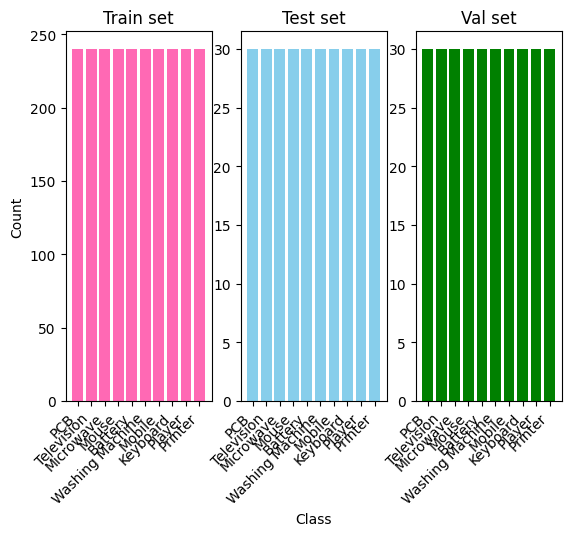

<Figure size 5000x3900 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt

#plot count for tain data
plt.subplot(1,3,1)
plt.bar(df_train['Class'], df_train['Count'], color = 'hotpink')
plt.title('Train set')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

#plot count for test data
plt.subplot(1,3,2)
plt.bar(df_test['Class'], df_test['Count'], color = 'skyblue')
plt.title('Test set')
plt.xlabel('Class')
plt.xticks(rotation=45, ha='right')

#plot count for val data
plt.subplot(1,3,3)
plt.bar(df_val['Class'], df_val['Count'], color = 'green')
plt.title('Val set')
plt.xticks(rotation=45, ha='right')

plt.figure(figsize=(50,39))
plt.show()

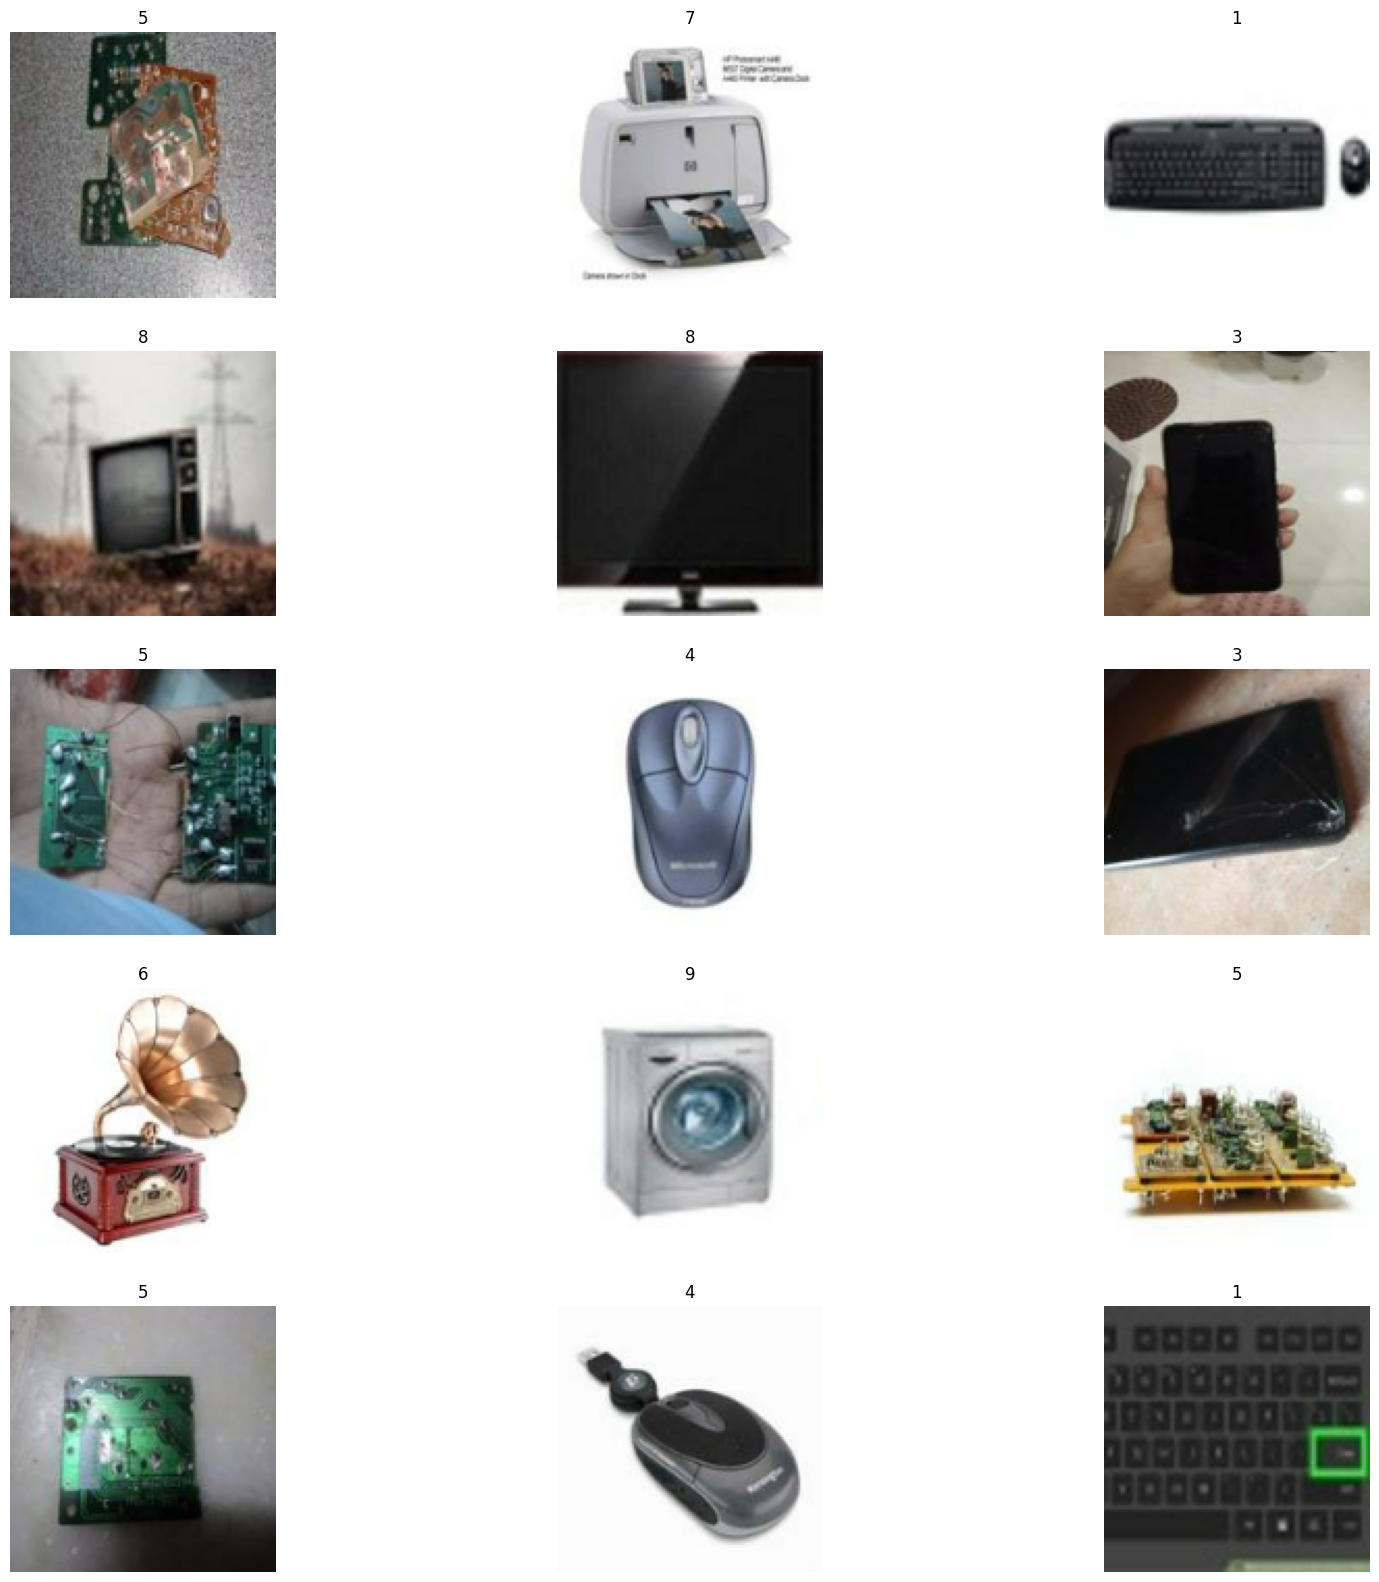

In [9]:
plt.figure(figsize=(20, 20))
for images, labels in data_train.take(1):
    for i in range(15):
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.35),
])

In [38]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(150, 150, 3), # Corrected input shape
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [40]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=5,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [41]:
epochs = 15

history = model.fit(
    data_train,
    validation_data=data_val,
    epochs=epochs,
    batch_size=100,
    callbacks=[early]
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - Accuracy: 0.5756 - loss: 1.2758 - val_Accuracy: 0.8933 - val_loss: 0.3744
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - Accuracy: 0.8543 - loss: 0.4406 - val_Accuracy: 0.8933 - val_loss: 0.3082
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - Accuracy: 0.8851 - loss: 0.3639 - val_Accuracy: 0.8933 - val_loss: 0.3173
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - Accuracy: 0.8938 - loss: 0.3037 - val_Accuracy: 0.9100 - val_loss: 0.2898
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - Accuracy: 0.9243 - loss: 0.2700 - val_Accuracy: 0.9233 - val_loss: 0.2645
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - Accuracy: 0.9341 - loss: 0.2038 - val_Accuracy: 0.8967 - val_loss: 0.3537
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - Accuracy: 0.9443 - loss: 0.1673 - val_Accuracy: 0.9167 - val_loss: 0.2857
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - Accuracy: 0.9400 - loss: 0.1819 - val_Accuracy: 0.9300 - v

In [42]:
model.summary() # Print the architecture summary of the  model

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 5, 5, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)

In [43]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 150, 150,  │          0 │ input_layer_10[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_4     │ (None, 150, 150,  │          0 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ normalization_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 75, 75,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 75, 75,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 38, 38,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 38, 38,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 38, 38,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 38, 38,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 38, 38,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 38, 38,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 38, 38,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 38, 38,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,155,648 (19.67 MB)

 Non-trainable params: 763,664 (2.91 MB)

In [44]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

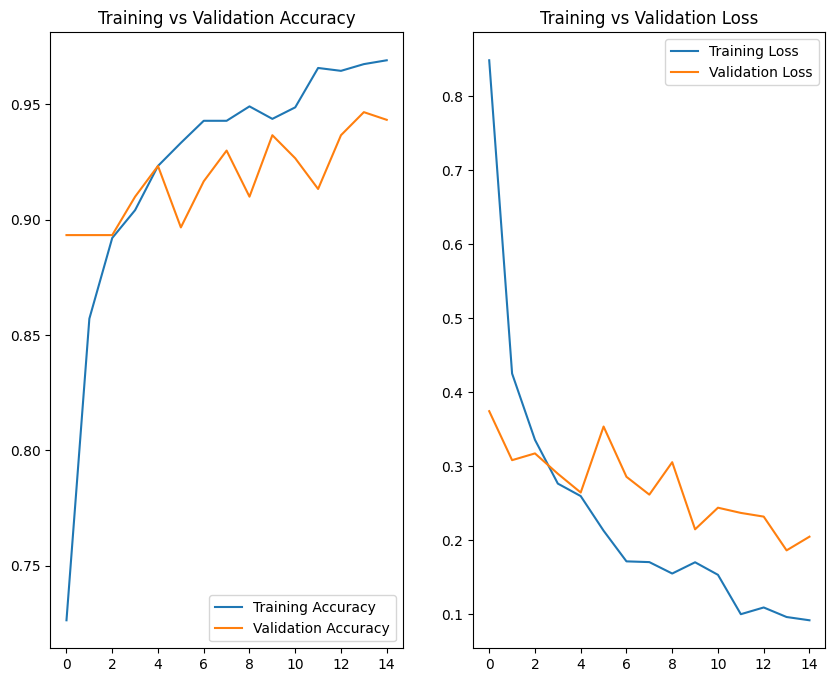

In [45]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots

In [48]:
loss, accuracy = model.evaluate(data_test)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 690ms/step - Accuracy: 0.9471 - loss: 0.1991
Test accuracy is0.9367, Test loss is 0.2239


In [51]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in data_test], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(data_test)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
[[28  0  0  0  0  2  0  0  0  0]
 [ 0 29  0  1  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  0  0  2  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  0 29  1  0  0  0]
 [ 1  0  0  0  1  0 27  1  0  0]
 [ 2  0  0  0  0  0  0 28  0  0]
 [ 0  0  3  0  0  0  0  1 26  0]
 [ 0  0  0  0  0  1  2  0  0 27]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        30
           1       1.00      0.97      0.98        30
           2       0.90      0.93      0.92        30
           3       0.97      1.00      0.98        30
           4       0.97      0.97      0.97        30
           5       0.91      0.97      0.94        30
           6       0.90      0.90      0.90        30
           7       0.90      0.93      0.92        30
           8       0.93      0.87      0.90        30
           9       1.00      0.90      0.95        30

    accuracy                      

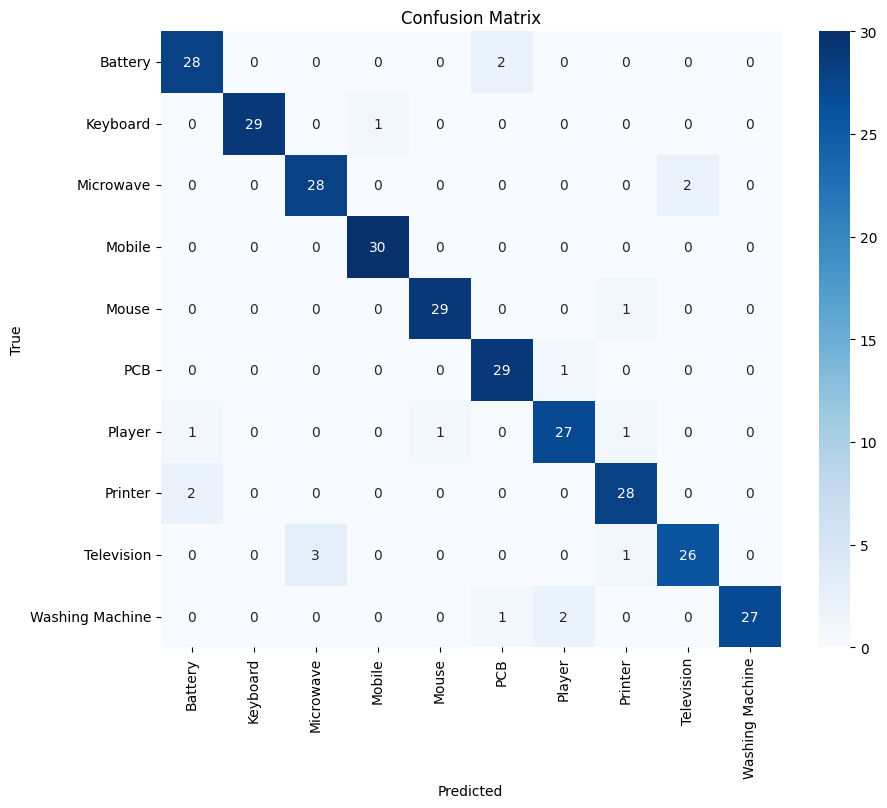

In [57]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=data_train.class_names,
            yticklabels=data_train.class_names,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()